# Choose settings

##### Choose your settings here

In [ ]:
# choose dataset
DATASET_NAME = 'cats-vs-dogs-large'  # needs to match folder name in FM/datasets
LOAD_AND_EMBED_DATASET_IN_BATCHES = True  # True for large datasets, False for small ones
USE_CACHED_EMBEDDINGS = 'CLIP_cats-vs-dogs-large.pkl'  # '' for loading the dataset normally, 'CREATE__{x}.pkl' for creating the cache file {x}.pkl, '{x}.pkl' for loading the cache file {x}.pkl
MISLABELED_INSTANCES = 'mislabeled_instances_cats-vs-dogs.pkl'  # if not '', but e.g. 'mislabeled_instances_cats-vs-dogs.pkl', the pickle file specifies which files to drop from the loaded embeddings

# choose how many image-label mismatches to insert
MISMATCH_PORTION = 0.01  # percentage of mismatching image-label pairs added
MANIPULATION_TYPES = [0.5, 0.5, 0.0, 0.0]  # how much of the MISMATCH_PORTION to produce by [exchanging images between classes, inserting images from other datasets, inserting randomly generated images, inserting placeholder images]
IMAGENET_EMBEDDINGS = 'CLIP_imagenet-subset.pkl'  # specify if MANIPULATION_TYPES[1] > 0


##### This part is calculated automatically

In [ ]:
datasets_path = '/content/drive/My Drive/FM/datasets/'
dataset_path = datasets_path + DATASET_NAME + '/'

if DATASET_NAME == 'cats-vs-dogs-large' or DATASET_NAME == 'train-small':
  LABELS = ['cat', 'dog']
elif DATASET_NAME == 'jellyfish-classification':
  LABELS = ['barrel jellyfish', 'compass jellyfish', 'lions mane jellyfish', 'moon jellyfish']
elif DATASET_NAME == 'traffic-signs':
  LABELS = ['30 kilometers per hour speed limit traffic sign', '80 kilometers per hour speed limit traffic sign', '100 kilometers per hour speed limit traffic sign', 'give way traffic sign', 'no entry traffic sign', 'no overtaking traffic sign', 'priority over oncoming traffic sign', 'stop sign']
else:
  raise ValueError('Invalid dataset selected or labels not set!')

assert 0 <= MISMATCH_PORTION <= 1, f'MISMATCH_PORTION must be in [0, 1] but is {MISMATCH_PORTION}'
assert len(MANIPULATION_TYPES) == 4 and sum(MANIPULATION_TYPES) == 1, f'MANIPULATION_TYPES must contain 4 entries that sum up to 1.0 but is {MANIPULATION_TYPES}'
assert MANIPULATION_TYPES[0] + MANIPULATION_TYPES[1] == 1, 'At the moment, only interclass corruption and imagenet corruption are implemented!'

# Load libraries

In [ ]:
# hacky way when hitting "run all" that libraries are not reloaded
try:
  torch.tensor([[0]])
  libraries_already_loaded = True
except:
  libraries_already_loaded = False

In [ ]:
if not libraries_already_loaded:
  ! pip install ftfy regex tqdm
  ! pip install git+https://github.com/openai/CLIP.git

In [ ]:
if not libraries_already_loaded:
  import torch
  from torchvision import transforms
  import clip
  from transformers import AutoImageProcessor, ViTModel
  import numpy as np
  from matplotlib import pyplot as plt
  from PIL import Image
  from pkg_resources import packaging
  import os
  from google.colab import drive
  from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
  import glob
  import pickle
  from scipy.spatial.distance import cosine

print("Torch version:", torch.__version__)

#from sklearn.metrics.pairwise import cosine_similarity #as cosine_similarity_sklearn
#def cosine_similarity(X, Y=None):
#  X = X.clone().detach().numpy()
#  if Y is not None:
#    Y = Y.clone().detach().numpy()
#  return torch.tensor(cosine_similarity_sklearn(X, Y))

Torch version: 2.1.0+cu121


In [ ]:
def calculate_column_average(matrix):
    """
    Calculates the average for each column in a PyTorch matrix.

    Parameters:
    - matrix: torch.Tensor
        The input matrix for which the column averages are to be calculated.

    Returns:
    - torch.Tensor
        A tensor containing the average value for each column of the input matrix.

    Raises:
    - TypeError:
        Raises an error if the input is not a PyTorch tensor.
    - ValueError:
        Raises an error if the input tensor is empty or has zero columns.
    """

    # Checking if the input is a PyTorch tensor
    if not isinstance(matrix, torch.Tensor):
        raise TypeError("Input should be a PyTorch tensor.")

    # Checking if the input tensor is empty or has zero columns
    if matrix.numel() == 0 or matrix.size(1) == 0:
        raise ValueError("Input tensor is empty or has zero columns.")

    # Calculating the column averages but taking out the entry for the same vector in the matrix (diagonal entry)
    column_sums = torch.sum(matrix, dim=0)
    column_counts = torch.tensor([matrix.size(0)] * (matrix.size(1)), dtype=torch.float32)
    column_averages = (column_sums -1) / (column_counts - 1)

    return column_averages

def cosine_similarity_matrix(embeddings_tensor):
    """
    Function to compute a similarity matrix using dot product

    Parameters:
    - embeddings: list of torch.Tensor
        List of embeddings of images produced with CLIP.

    Returns:
    - similarity_matrix: numpy.ndarray
        2D numpy array representing the similarity matrix between the embeddings.
        Each element (i, j) in the matrix represents the similarity between embeddings[i] and embeddings[j].
        The similarity score between the two embeddings is calculated using cos similarity. The score ranges from 0 to 1,
        where 0 indicates completely dissimilar embeddings and 1 indicates identical embeddings.
    """

    """
    # Calculating the cosine distance between the two embeddings
    distance = cosine(embedding1, embedding2)

    # Converting the distance to similarity score
    similarity = 1 - distance

    return similarity
    """

    # Normalizing the embeddings
    embeddings_tensor = torch.nn.functional.normalize(embeddings_tensor, dim=1)

    # Computing the similarity matrix using dot product
    similarity_matrix = torch.matmul(embeddings_tensor, embeddings_tensor.T)

    return similarity_matrix

from sklearn.metrics.pairwise import cosine_similarity as cosine_similarity_sklearn
def cosine_similarity(x, y=None):
  if y is None:
    return cosine_similarity_matrix(x)
  return cosine_similarity_sklearn(x, y)

# Mounting storage

In [ ]:
drive.mount('/content/drive')
!ls "{datasets_path}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AlexNet_cats-vs-dogs-large.pkl			 indizes_clean_Anni.txt
AlexNet_imagenet-subset.pkl			 jellyfish-classification
AlexNet_traffic-signs.pkl			 mislabeled_instances_cats-vs-dogs_CATS_ONLY.pkl
ALIGN_cats-vs-dogs-large.pkl			 mislabeled_instances_cats-vs-dogs.pkl
ALIGN_imagenet-subset.pkl			 note.txt
ALIGN_traffic-signs.pkl				 text_dog_embeddings_more.pkl
cats-dogs-big_ids.pkl				 text_dog_embeddings.pkl
cats-dogs-big.pkl				 text_random_embeddings_more.pkl
cats-vs-dogs-large				 text_random_embeddings.pkl
CLIP_cats-vs-dogs-large.pkl			 traffic-signs
CLIP_imagenet-subset.pkl			 train-small
CLIP_traffic-signs.pkl				 ViT-CLS_cats-vs-dogs-large.pkl
dog_wrong_2_12.txt				 ViT-CLS_imagenet-subset.pkl
dog_wrong.txt					 ViT-CLS_traffic-signs.pkl
image_embeddings__cats-vs-dogs.pkl		 ViT-pooling_cats-vs-dogs-large.pkl
image_embeddings__traffic-signs.pkl		 ViT-pooling_i

# Define dataset loader

In [ ]:
def load_dataset(folder_path, labels):

    # Checking if the provided folder path exists
    if not os.path.exists(folder_path):
        raise ValueError("Folder path does not exist.")

    images = {}
    for label in labels:
      images[label] = []

    # Looping through all files in the folder
    for i, filename in enumerate(glob.glob(folder_path + '**/*', recursive=True)):

      if i % 1000 == 0:
        print(i, 'files loaded')

      try:
        img = Image.open(filename).convert('RGB')
      except:
        continue

      label_found = False
      for label in labels:
        if label in '/'.join(filename.split('/')[-2:]):
          if label_found:
            raise ValueError(f"Label of {filename} is ambiguous.")
          label_found = True
          images[label].append(img)

      if not label_found:
        raise ValueError(f"No label for {filename} found.")

    print(i+1, 'files loaded')

    return images

def get_embeddings_dict_batchwise(folder_path, labels, model, preprocess, batch_size=64):

  # Checking if the provided folder path exists
  if not os.path.exists(folder_path):
    raise ValueError("Folder path does not exist.")

  image_embeddings = {}
  for label in labels:
    image_embeddings[label] = []

  images = {}
  for label in labels:
    images[label] = []

  # Looping through all files in the folder
  all_files = glob.glob(folder_path + '**/*', recursive=True)
  for n_instances_processed, filename in enumerate(all_files):

    try:
      img = Image.open(filename).convert('RGB')
    except:
      continue

    # Find label of the image
    label_found = False
    for label in labels:
      if label in '/'.join(filename.split('/')[-2:]):
        if label_found:
          raise ValueError(f"Label of {filename} is ambiguous.")
        label_found = True
        images[label].append(img)
    if not label_found:
      raise ValueError(f"No label for {filename} found.")

    # Get embeddings if already a batch is full
    if n_instances_processed % batch_size == 0 and n_instances_processed > 0 or n_instances_processed == len(all_files) - 1:
      for label in labels:
        if len(images[label]) == 0:
          continue
        with torch.no_grad():
          processed_images = torch.cat(([preprocess(img).unsqueeze(0) for img in images[label]]))
          image_embeddings[label].append(model.encode_image(processed_images.to(device)))
          del processed_images
      images = {}
      for label in labels:
        images[label] = []
      print(n_instances_processed, 'loaded and encoded')

  # Convert list of embeddings to tensor
  for label in labels:
    image_embeddings[label] = torch.cat((image_embeddings[label]))

  return image_embeddings

# Load and embed dataset

In [ ]:
if USE_CACHED_EMBEDDINGS != '' and USE_CACHED_EMBEDDINGS.split('__')[0] != 'CREATE':

  # load embeddings of previous execution from pickle file
  pickle_file = datasets_path + USE_CACHED_EMBEDDINGS
  with open(pickle_file, 'rb') as f:
    image_embeddings = pickle.load(f)

  print('Embeddings loaded from', pickle_file)

else:

  if LOAD_AND_EMBED_DATASET_IN_BATCHES:

    # load and embed images in batches (to save GPU memory and especially RAM)
    image_embeddings = get_embeddings_dict_batchwise(dataset_path, LABELS, model, preprocess, batch_size=512)

  else:

    # load images
    images = load_dataset(dataset_path, LABELS)

    # embed images and text
    image_embeddings = {}
    for label in LABELS:
      processed_images = torch.cat(([preprocess(img).unsqueeze(0) for img in images[label]])).to(device)
      with torch.no_grad():
        image_embeddings[label] = model.encode_image(processed_images)

  # move embeddings to cpu and convert to suitable datatype for further analysis
  for key in image_embeddings:
    image_embeddings[key] = image_embeddings[key].cpu().type(torch.float)

  # save embeddings in pickle file if desired (enabled to reload them later on)
  if USE_CACHED_EMBEDDINGS != '' and USE_CACHED_EMBEDDINGS.split('__')[0] == 'CREATE':
    pickle_filename = '__'.join(USE_CACHED_EMBEDDINGS.split('__')[1:])  # remove prefix 'CREATE__'
    pickle_file = datasets_path + pickle_filename
    with open(pickle_file, 'wb') as f:
      pickle.dump(image_embeddings, f)
    print('Embeddings stored in', pickle_file)

# save embedding dimension for creation of reference vectors etc.
embedding_dim = image_embeddings[LABELS[0]].shape[1]


Embeddings loaded from /content/drive/My Drive/FM/datasets/CLIP_cats-vs-dogs-large.pkl


In [ ]:
LABELS_POLLUTION_ALSO = LABELS.copy()
mislabeled_indices = None

if MISLABELED_INSTANCES != '':
  with open(datasets_path + MISLABELED_INSTANCES, 'rb') as f:
    mislabeled_indices = pickle.load(f)
  for label in mislabeled_indices:
    if len(mislabeled_indices[label]) == 0 or sum(mislabeled_indices[label]) == 0:
      continue
    image_embeddings[label + '_pollution'] = image_embeddings[label][mislabeled_indices[label]].clone().detach()
    image_embeddings[label + '_clean'] = image_embeddings[label][[not i for i in mislabeled_indices[label]]].clone().detach()
    LABELS_POLLUTION_ALSO += [label + '_pollution', label + '_clean']

if MANIPULATION_TYPES[1] > 0:
  pickle_file = datasets_path + IMAGENET_EMBEDDINGS
  with open(pickle_file, 'rb') as f:
    image_embeddings['imagenet_subset'] = pickle.load(f)['val']
  print('Embeddings loaded from', pickle_file)
  LABELS_POLLUTION_ALSO += ['imagenet_subset']

print('LABELS =', LABELS)
print('LABELS_POLLUTION_ALSO =', LABELS_POLLUTION_ALSO)
for k in image_embeddings:
  print(k, len(image_embeddings[k]))

Embeddings loaded from /content/drive/My Drive/FM/datasets/CLIP_imagenet-subset.pkl
LABELS = ['cat', 'dog']
LABELS_POLLUTION_ALSO = ['cat', 'dog', 'cat_pollution', 'cat_clean', 'dog_pollution', 'dog_clean', 'imagenet_subset']
cat 12502
dog 12499
cat_pollution 25
cat_clean 12477
dog_pollution 24
dog_clean 12475
imagenet_subset 869


In [ ]:
image_embeddings

{'cat': tensor([[-0.0387,  0.2160,  0.1780,  ...,  0.4079,  0.1008,  0.1362],
         [-0.1506,  0.3018,  0.3432,  ...,  0.6637,  0.0397,  0.3144],
         [ 0.1646, -0.0336, -0.1467,  ...,  1.0171, -0.0948,  0.6094],
         ...,
         [-0.1360, -0.0471,  0.0113,  ...,  1.0467, -0.1928, -0.1577],
         [-0.1023, -0.3004, -0.0049,  ...,  0.7930, -0.2246,  0.1258],
         [-0.2691, -0.2053, -0.2918,  ...,  0.8326,  0.1015,  0.0920]]),
 'dog': tensor([[-0.1831, -0.0755, -0.2626,  ...,  0.7828,  0.4646,  0.3408],
         [ 0.1424, -0.1356, -0.3166,  ...,  0.6080,  0.1165, -0.3293],
         [ 0.1598, -0.4937, -0.4558,  ...,  0.3501, -0.0652, -0.0285],
         ...,
         [-0.0679,  0.2011, -0.2894,  ...,  0.6716,  0.1807, -0.2719],
         [-0.1221,  0.1625, -0.0319,  ...,  0.8154,  0.1028,  0.1396],
         [ 0.2895,  0.0374, -0.0760,  ...,  1.6849, -0.0034,  0.1964]]),
 'cat_pollution': tensor([[ 0.2137, -0.0943, -0.0060,  ...,  1.4040,  0.3421, -0.1053],
         [-0.0

## Adjust with hand-proofed data

In [ ]:
def load_from_pickle (datasets_path, USE_CACHED_EMBEDDINGS ="cats-vs-dogs.pkl" ):
  image_embeddings = []
  pickle_file = datasets_path + USE_CACHED_EMBEDDINGS
  with open(pickle_file, 'rb') as f:
    image_embeddings = pickle.load(f)
  return image_embeddings

Corresponding embeddings and ids

In [ ]:
# embeddings in order corresponding to stored ids from next cell

image_embeddings["dog"] = load_from_pickle (datasets_path, USE_CACHED_EMBEDDINGS ="cats-dogs-big.pkl" )["dog"]

num_instances = image_embeddings["dog"].shape[0]
# array of all <dog> embeddings for easier use when arrat necessary
embeddings_dog_big_arr = [ image_embeddings["dog"][i,:].numpy() for i in range(num_instances)]

In [ ]:
ids_big_catDog = load_from_pickle (datasets_path, USE_CACHED_EMBEDDINGS ="cats-dogs-big_ids.pkl" )

In [ ]:
unique_elements = set(ids_big_catDog["dog"])
wrongs=[]
for i in ids_big_catDog["dog"]:
  if not i.startswith("/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/"):
    wrongs.append(i)
len(wrongs)

101

In [ ]:
image_embeddings["dog"].shape

torch.Size([12600, 512])

In [ ]:
image_embeddings["dog"] = image_embeddings["dog"][101:]

In [ ]:
ids_big_catDog["dog"]=ids_big_catDog["dog"][101:]

In [ ]:
#num_instances = image_embeddings["dog"].shape[0]

Ids of wrong dog pictures (hand-checked)

In [ ]:
ids_wrong_dogs = []
ids_wrong_cats = []
ground_truth= [0] * image_embeddings["dog"].shape[0]

with open("/content/drive/My Drive/FM/pollution_files.txt", 'r') as file:
  # Reading the contents of the file and storing them in a list
  file_contents = file.readlines()[1:-1]

  # Removing any leading or trailing whitespace from each line
  file_contents = [line.strip().replace(",", "").replace(".jpg", "").replace("'", "") for line in file_contents]
  for line in file_contents:
    split = line.strip().replace(",", "").replace(".jpg", "").split("/")
    if split[0]=="Dog":
      ids_wrong_dogs.append("/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/"+split[1]+".jpg")
      ground_truth[int(split[1])]=1
    else:
      ids_wrong_cats.append("/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/cat/"+split[1]+".jpg")


In [ ]:
ids_wrong_dogs

['/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/1043.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/1194.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/1773.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/2614.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/2877.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/4334.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/4367.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/5490.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/5604.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/6475.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/7413.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/10161.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/10237.jpg',
 '/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/dog/1

In [ ]:
'''
ids_wrong_dogs = []
with open(datasets_path + "dog_wrong_2_12.txt", 'r') as file:
  lines = file.readlines()
  ids_wrong_dogs = ["/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/"+line.strip() for line in lines]
  '''

'\nids_wrong_dogs = []\nwith open(datasets_path + "dog_wrong_2_12.txt", \'r\') as file:\n  lines = file.readlines()\n  ids_wrong_dogs = ["/content/drive/My Drive/FM/datasets/cats-vs-dogs-large/"+line.strip() for line in lines]\n  '

Clean dogs

In [ ]:
clean_dogs = []
for i, emb in zip(ids_big_catDog["dog"],embeddings_dog_big_arr):
  if not(i in ids_wrong_dogs):
    clean_dogs.append(emb)

 Imagenet pics in array for easier handling with dataset creation (test phase external pollution)

In [ ]:
imagenet_arr = [ image_embeddings["imagenet_subset"][i,:].numpy() for i in range(image_embeddings["imagenet_subset"].shape[0])]

# DL Dataset preparation

## General preparations


### Model init (CLIP)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

### Load textual embeddings

In [ ]:
def load_from_pickle (datasets_path, USE_CACHED_EMBEDDINGS ="cats-vs-dogs.pkl" ):
  image_embeddings = []
  pickle_file = datasets_path + USE_CACHED_EMBEDDINGS
  with open(pickle_file, 'rb') as f:
    image_embeddings = pickle.load(f)
  return image_embeddings

In [ ]:
text_random_embeddings = load_from_pickle (datasets_path, USE_CACHED_EMBEDDINGS ="text_random_embeddings_more.pkl" )
text_dog_embeddings = load_from_pickle (datasets_path, USE_CACHED_EMBEDDINGS ="text_dog_embeddings_more.pkl" )

In [ ]:
len(text_random_embeddings)

1103

In [ ]:
len(text_dog_embeddings)

511

### Fcts for similarity calculation

In [ ]:
import numpy as np
import torch
from scipy.spatial.distance import cosine

def calc_similarity_matrix_embeddings(embeddings_tensor, embeddings_tensor2 = True):
    """
    Function to compute a similarity matrix using dot product

    Parameters:
    - embeddings: list of torch.Tensor
        List of embeddings of images produced with CLIP.

    Returns:
    - similarity_matrix: numpy.ndarray
        2D numpy array representing the similarity matrix between the embeddings.
        Each element (i, j) in the matrix represents the similarity between embeddings[i] and embeddings[j].
        The similarity score between the two embeddings is calculated using cos similarity. The score ranges from 0 to 1,
        where 0 indicates completely dissimilar embeddings and 1 indicates identical embeddings.
    """

    """
    # Calculating the cosine distance between the two embeddings
    distance = cosine(embedding1, embedding2)

    # Converting the distance to similarity score
    similarity = 1 - distance

    return similarity
    """
    if isinstance(embeddings_tensor2, bool):
      embeddings_tensor2 = embeddings_tensor

    # Normalizing the embeddings
    embeddings_tensor = torch.nn.functional.normalize(embeddings_tensor, dim=1)
    embeddings_tensor2 = torch.nn.functional.normalize(embeddings_tensor2, dim=1)

    # Computing the similarity matrix using dot product
    similarity_matrix = torch.matmul(embeddings_tensor, embeddings_tensor2.T)

    return similarity_matrix

In [ ]:
def calculate_column_average(matrix):
    """
    Calculates the average for each column in a PyTorch matrix.

    Parameters:
    - matrix: torch.Tensor
        The input matrix for which the column averages are to be calculated.

    Returns:
    - torch.Tensor
        A tensor containing the average value for each column of the input matrix.

    Raises:
    - TypeError:
        Raises an error if the input is not a PyTorch tensor.
    - ValueError:
        Raises an error if the input tensor is empty or has zero columns.
    """

    # Checking if the input is a PyTorch tensor
    if not isinstance(matrix, torch.Tensor):
        raise TypeError("Input should be a PyTorch tensor.")

    # Checking if the input tensor is empty or has zero columns
    if matrix.numel() == 0 or matrix.size(1) == 0:
        raise ValueError("Input tensor is empty or has zero columns.")

    # Calculating the column averages but taking out the entry for the same vector in the matrix (diagonal entry)
    column_sums = torch.sum(matrix, dim=0)
    column_counts = torch.tensor([matrix.size(0)] * (matrix.size(1)), dtype=torch.float32)
    column_averages = (column_sums -1) / (column_counts - 1)

    return column_averages

In [ ]:
similarity_matrix = calc_similarity_matrix_embeddings(image_embeddings["dog"])
avg_similarity_imgs = calculate_column_average(similarity_matrix)

## Approach 1: Training on embeddings

### Helper fcts

In [ ]:
import random
import math

def generate_random_vectors(n: int, size: int) -> list:

    vectors = []
    for _ in range(n):
        vector = [random.uniform(-1, 1) for _ in range(size)]
        vectors.append(vector)

    return vectors

def normalize_vectors(vectors: list) -> list:

    normalized_vectors = []
    for vector in vectors:
        magnitude = math.sqrt(sum([x**2 for x in vector]))
        normalized_vector = [x / magnitude for x in vector]
        normalized_vectors.append(torch.tensor(normalized_vector))

    return normalized_vectors


In [ ]:
def create_train_assumed_correct(dataset_img_embeddings, text_random_embeddings,
                                 text_class_embeddings, avg_similarity_imgs,
                                  random_vec_size = 512):




  import string
  import random

  # Assuming X is your data matrix (features) and y is the corresponding labels
  # Make sure to replace this with your actual dataset

  # Split the data into training and testing sets
  dict_self_similarity = {}
  for i, el in enumerate(avg_similarity_imgs):
      dict_self_similarity[i] = el


  sorted_similarities = sorted(dict_self_similarity.items(), key=lambda x: x[1])
  n = len(dict_self_similarity)
  q3_index = int((3 *n )// 6)
  q4_index = int((4 * n) // 6)
  assumed_correct = sorted_similarities[q3_index:q4_index]

   # Generate random vectors
  random_vectors = generate_random_vectors(int(4*n/18)+ text_class_embeddings.shape[0] - text_random_embeddings.shape[0], random_vec_size)

  # Normalize the random vectors
  normalized_random_vectors = normalize_vectors(random_vectors)
  extr_embed = lambda index: dataset_img_embeddings[index]

  embeddings_img_assumed_correct = [ extr_embed(index) for index in dict(assumed_correct).keys()]
  train = {}
  for emb in (embeddings_img_assumed_correct + [text_class_embeddings[i] for i in range(text_class_embeddings.shape[0])]):
    train[emb] = 1
  for emb in (normalized_random_vectors +  [text_random_embeddings[i] for i in range(text_random_embeddings.shape[0])]):
    train[emb] = 0

  l = list(train.items())


  X_train = [item[0] for item in l]
  y_train = [item[1] for item in l]

  return X_train, y_train

### Dataset prep

#### Train dataset

In [ ]:
random_vectors = generate_random_vectors(2, 512)

  # Normalize the random vectors
normalized_random_vectors = normalize_vectors(random_vectors)
normalized_random_vectors[0]

tensor([ 3.5277e-02, -7.4546e-02,  3.1767e-03, -1.1065e-02,  5.5553e-02,
         7.2877e-02, -3.6328e-02, -6.7653e-03, -3.0894e-02, -3.2304e-02,
        -4.0970e-02, -4.0204e-02,  4.3627e-02, -1.9403e-03, -5.1638e-02,
         1.0137e-02,  5.6698e-02, -5.5362e-02, -2.4274e-02,  5.9476e-02,
         3.4961e-02,  6.1573e-02,  2.5992e-02, -2.1257e-02,  7.1238e-03,
         3.2132e-02,  7.3589e-02, -4.3769e-02,  7.4544e-02,  6.1946e-02,
         3.8834e-02, -7.0911e-02, -3.5897e-02,  3.2172e-03, -2.5926e-02,
        -4.4766e-03, -3.3482e-02, -1.0086e-02, -3.2393e-02, -6.5186e-02,
        -5.0215e-02,  7.9141e-03,  5.9520e-02, -4.0872e-02, -6.8543e-02,
        -4.8414e-02, -2.6258e-02,  6.9522e-02,  5.3061e-02,  4.0044e-02,
        -7.0847e-02,  5.2114e-02,  4.8656e-02,  9.4198e-03, -2.7569e-02,
         4.6217e-02, -5.5924e-02, -1.0286e-03, -6.7794e-02,  6.7622e-03,
         3.1535e-02,  7.1226e-02, -5.0939e-02,  1.4079e-02, -1.9382e-03,
        -6.8833e-02,  7.2125e-02, -6.3024e-02,  4.2

In [ ]:
run =48

In [ ]:
similarity_matrix_dog = calc_similarity_matrix_embeddings(image_embeddings["dog"])
avg_similarity_dog_imgs = calculate_column_average(similarity_matrix_dog)

In [ ]:
X_train_embeddings, y_train_embeddings = create_train_assumed_correct(dataset_img_embeddings = image_embeddings["dog"],
                                                                      text_random_embeddings = text_random_embeddings,
                                                                      text_class_embeddings = text_dog_embeddings,
                                                                      avg_similarity_imgs = avg_similarity_dog_imgs, random_vec_size = 512)


#### Test dataset for internal pollution

In [ ]:
X_test_embeddings_internal = []
y_test_embeddings_internal = []
for id, emb in zip(ids_big_catDog["dog"],image_embeddings["dog"]):
  X_test_embeddings_internal.append(emb)
  if id in ids_wrong_dogs:
    y_test_embeddings_internal.append(0)
  else:
    y_test_embeddings_internal.append(1)

#### Test dataset for external pollution

In [ ]:
# TODO

X_test_embeddings_external = clean_dogs + imagenet_arr
y_test_embeddings_external = [1 for i in range(len(clean_dogs))] + [0 for i in range(len(imagenet_arr))]

## Approach 2: Training on FE

### Helper fcts

In [ ]:
def retrieve_embeddings_for_txt_indices(txt_file_name, embeddings_arr, max_num_instances):
  with open(datasets_path + txt_file_name, 'r') as file:
    # Read all lines from the file
    lines = file.readlines()

    # Initialize an empty list to store the split text from each line
    indices = []

    # Iterate over each line and split the text
    for i, line in enumerate(lines):
      if i< max_num_instances:
        # Remove leading and trailing whitespaces from the line
        line = line.strip()

        # Split the line by whitespace
        indices.append(line.split(".")[0])
      else:
        break


  return [embeddings_arr[int(i)] for i in indices], indices

In [ ]:
def feature_engineer_group(embeddings_for_dataset,
                           embeddings_assumed_correct,
                           text_embeddings_class,
                           class_label,
                           X_train_fe, y_train_fe):
  similarity_matrix = calc_similarity_matrix_embeddings(embeddings_assumed_correct, embeddings_for_dataset)
  avg_similarity = calculate_column_average(similarity_matrix)
  avg_sim_arr = avg_similarity.numpy()

  for index, embedding in enumerate(embeddings_for_dataset):

    text_embeddings_class_prob = (100.0 * embedding.T @ text_embeddings_class.T).softmax(dim=-1)

    X_train_fe.append([avg_sim_arr[index]]+text_embeddings_class_prob.tolist())
    y_train_fe.append(class_label)

  return X_train_fe, y_train_fe

### Train Dataset

In [ ]:
import tensorflow as tf

with torch.no_grad():
    text_embeddings_dogs = model.encode_text(clip.tokenize(["a picture of dog", "a picture of dogs", "a picture of person with dog","a drawing of dog","a picture of something", "a picture of nothing"]).to(device))

In [ ]:
# Determine assumed correct instances (have very high self-similarity to rest of dataset)

dict_self_similarity = {}
for i, el in enumerate(avg_similarity_imgs):
    dict_self_similarity[i] = el


sorted_similarities = sorted(dict_self_similarity.items(), key=lambda x: x[1])
n = len(dict_self_similarity)
assumed_correct = sorted_similarities[:int(9*n/10)]
assumed_correct_2000 = [assumed_correct[i] for i in random.sample(range(0, len(assumed_correct)), 2000)]

extr_embed = lambda index: [index]
img_assumed_correct_2000 = [ embeddings_dog_big_arr[int(index)] for index in dict(assumed_correct_2000).keys()]


In [ ]:
X_train_fe =[]
y_train_fe = []

emb_2000_tensor = torch.from_numpy(np.asarray(img_assumed_correct_2000))

# (assumed) CORRECT instances

X_train_fe, y_train_fe = feature_engineer_group(emb_2000_tensor, image_embeddings["dog"],
                           text_embeddings_dogs, 1, X_train_fe, y_train_fe)

X_train_fe, y_train_fe = feature_engineer_group(text_dog_embeddings, emb_2000_tensor,
                           text_embeddings_dogs, 1, X_train_fe, y_train_fe)
len_1 = len(y_train_fe) # to check later balances of wrong and correct instances in dataset



# (assumed) FALSE instances
tensor = np.random.rand(1500,512)

# Normalizing the column values
normalized_tensor = torch.from_numpy(tensor / np.linalg.norm(tensor, axis=0)).float()

X_train_fe, y_train_fe = feature_engineer_group(normalized_tensor, emb_2000_tensor,
                           text_embeddings_dogs, 0, X_train_fe, y_train_fe)

X_train_fe, y_train_fe = feature_engineer_group(text_random_embeddings, emb_2000_tensor,
                           text_embeddings_dogs, 0, X_train_fe, y_train_fe)

# CHeck balance of wrong and correct instances
print("text random embeddings instances: "+str(len(text_random_embeddings)))
print("correct instances: "+str(len_1))
print("incorrect instances: "+str(len(y_train_fe)-len_1))

text random embeddings instances: 1103
correct instances: 2511
incorrect instances: 2603


### Test dataset for **internal** pollution

In [ ]:
X_test_fe_internal = []
y_test_fe_internal = []
avg_sim_arr = avg_similarity_imgs.numpy()

for index, emb_img in enumerate(image_embeddings["dog"]):
  text_embeddings_dogs_prob = (100.0 * emb_img.T @ text_embeddings_dogs.T).softmax(dim=-1)

  X_test_fe_internal.append([avg_sim_arr[index]]+ text_embeddings_dogs_prob.tolist())
  if ids_big_catDog["dog"][index] in ids_wrong_dogs:
    y_test_fe_internal.append(0)
  else:
    y_test_fe_internal.append(1)

### Test dataset for **external** pollution

In [ ]:

X_test_fe_external = []
y_test_fe_external = [1 for i in range(len(clean_dogs))] + [0 for i in range(len(imagenet_arr))]
similarity_matrix = calc_similarity_matrix_embeddings(image_embeddings["dog"], torch.from_numpy(np.asarray(clean_dogs + imagenet_arr)))
avg_similarity = calculate_column_average(similarity_matrix)
avg_sim_arr = avg_similarity.numpy()
for index, emb_img in enumerate(clean_dogs + imagenet_arr):
  emb_img_tensor =torch.from_numpy(emb_img)
  text_embeddings_dogs_prob = (100.0 * emb_img_tensor.T @ text_embeddings_dogs.T).softmax(dim=-1)

  X_test_fe_external.append([avg_sim_arr[index]]+ text_embeddings_dogs_prob.tolist())


# Models internal pollution

## Setup

In [ ]:
from collections import Counter

In [ ]:
predictions_internal ={}
predictions_external = {}
predicted_filenames_internal = {}

## On embeddings

### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(solver='sgd',  hidden_layer_sizes=(5, 2), random_state=1)

clf_mlp.fit([x.numpy() for x in X_train_embeddings], y_train_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(5, 2), random_state=1, solver='sgd')

In [ ]:
predictions_internal["Embeddings: MLP (ReLu + SGD)"] = clf_mlp.predict(np.stack(X_test_embeddings_internal))
predictions_external["Embeddings: MLP (ReLu + SGD)"] = clf_mlp.predict(np.stack(X_test_embeddings_external))

### MLP with threshold

In [ ]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(solver='sgd',  hidden_layer_sizes=(5, 2), random_state=1)

clf_mlp.fit([x.numpy() for x in X_train_embeddings], y_train_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(5, 2), random_state=1, solver='sgd')

In [ ]:
detect_outlier = lambda x: 0 if x >0.4 else 1

predictions_internal["Embeddings: MLP with threshold (ReLu + SGD)"] = [detect_outlier(i[0]) for i in clf_mlp.predict_proba(np.stack(X_test_embeddings_internal))]
predictions_external["Embeddings: MLP with threshold (ReLu + SGD)"] = [detect_outlier(i[0]) for i in clf_mlp.predict_proba(np.stack(X_test_embeddings_external))]

### SVC with sigmoid

In [ ]:
from sklearn import svm

clf_sigmoid = svm.SVC(kernel='sigmoid', gamma='scale')

clf_sigmoid.fit(np.stack(X_train_embeddings), np.stack(y_train_embeddings))

SVC(kernel='sigmoid')

In [ ]:
predictions_internal["Embeddings: SVC with sigmoid"] = clf_sigmoid.predict(np.stack(X_test_embeddings_internal))
predictions_external["Embeddings: SVC with sigmoid)"] = clf_sigmoid.predict(np.stack(X_test_embeddings_external))

### SVC with RBF

In [ ]:
from sklearn import svm

clf_sigmoid = svm.SVC(kernel='rbf', gamma='scale')

clf_sigmoid.fit(np.stack(X_train_embeddings), np.stack(y_train_embeddings))

SVC()

In [ ]:
predictions_internal["Embeddings: SVC with RBF"] = clf_sigmoid.predict(np.stack(X_test_embeddings_internal))
predictions_external["Embeddings: SVC with RBF"] = clf_sigmoid.predict(np.stack(X_test_embeddings_external))

## FE

### MLP: ReLu + SGD

In [ ]:
from sklearn.neural_network import MLPClassifier

clf_mlp_fe = MLPClassifier(solver='sgd',  hidden_layer_sizes=(7, 2), random_state=1)

clf_mlp_fe.fit(X_train_fe, y_train_fe)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(7, 2), random_state=1, solver='sgd')

In [ ]:
predictions_internal["FE: MLP (ReLu + SGD)"] = clf_mlp_fe.predict(np.stack(X_test_fe_internal))
predictions_external["FE: MLP (ReLu + SGD)"] = clf_mlp_fe.predict(np.stack(X_test_fe_external))

In [ ]:
print(Counter(predictions_internal["FE: MLP (ReLu + SGD)"]).keys()) # equals to list(set(words))
print(Counter(predictions_internal["FE: MLP (ReLu + SGD)"]).values())

dict_keys([1, 0])
dict_values([12478, 21])


### With threshold

In [ ]:
from sklearn.neural_network import MLPClassifier

clf_mlp_fe = MLPClassifier(solver='sgd',  hidden_layer_sizes=(5, 2), random_state=1)

clf_mlp_fe.fit(X_train_fe, y_train_fe)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(5, 2), random_state=1, solver='sgd')

In [ ]:
detect_outlier = lambda x: 0 if x >0.4 else 1

predictions_internal["FE: MLP with threshold"] =[detect_outlier(i[0]) for i in clf_mlp_fe.predict_proba(np.stack(X_test_fe_internal))]
predictions_external["FE: MLP with threshold"] = [detect_outlier(i[0]) for i in clf_mlp_fe.predict_proba(np.stack(X_test_fe_external))]

### SVC with RBF

In [ ]:
from sklearn import svm

clf_rbf = svm.SVC(gamma='scale')

clf_rbf.fit(np.stack(X_train_fe), np.stack(y_train_fe))

SVC()

In [ ]:
predictions_internal["FE: SCV with RBF"] = clf_rbf.predict(np.stack(X_test_fe_internal))
predictions_external["FE: SVC with RBF"] = clf_rbf.predict(np.stack(X_test_fe_external))

### SVC with Sigmoid

In [ ]:
from sklearn import svm

clf_sigmoid = svm.SVC(kernel='sigmoid', gamma='scale')

clf_sigmoid.fit(np.stack(X_train_fe), np.stack(y_train_fe))

SVC(kernel='sigmoid')

In [ ]:
predictions_internal["FE: SCV with Sigmoid"] = clf_rbf.predict(np.stack(X_test_fe_internal))
predictions_external["FE: SVC with Sigmoid"] = clf_rbf.predict(np.stack(X_test_fe_external))

## Ensembles

### Ensemble Embeddings MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

y=[]
y_external = []
detect_outlier = lambda x: 0 if x >0.48 else 1

for r in [random.randint(1,10000)  for i in range(20)]:
  clf_mlp = MLPClassifier(solver='sgd',  hidden_layer_sizes=(5, 2), random_state=r)

  clf_mlp.fit([x.numpy() for x in X_train_embeddings], y_train_embeddings)

  y_pred = [detect_outlier(i[0]) for i in clf_mlp.predict_proba(np.stack(X_test_embeddings_internal))]
  if np.count_nonzero(y_pred)>0.99*num_instances:
    if  y ==[]:
      y=y_pred
    else:
      for i,e in enumerate(clf_mlp.predict_proba(np.stack(X_test_embeddings_internal))):
        if detect_outlier(e[0])==0:
          y[i]=0


  y_pred = [detect_outlier(i[0]) for i in clf_mlp.predict_proba(np.stack(X_test_embeddings_external))]
  if np.count_nonzero(y_pred)>0.99*num_instances:
    if  y_external ==[]:
      y_external=y_pred
    else:
      for i,e in enumerate(clf_mlp.predict_proba(np.stack(X_test_embeddings_external))):
        if detect_outlier(e[0])==0:
          y_external[i]=0

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
predictions_internal["Embeddings Ensemble MLP (ReLu + SGD)"] = y
predictions_external["Embeddings Ensemble MLP (ReLu + SGD)"] = y_external

In [ ]:
np.count_nonzero(y)

12474

### Ensemble Embeddings SVC and MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

y=[]
y_external =[]
detect_outlier = lambda x: 0 if x >0.48 else 1

for r in [random.randint(1,10000)  for i in range(20)]:
  clf_mlp = MLPClassifier(solver='sgd',  hidden_layer_sizes=(5, 2), random_state=r)

  clf_mlp.fit([x.numpy() for x in X_train_embeddings], y_train_embeddings)

  y_pred = [detect_outlier(i[0]) for i in clf_mlp.predict_proba(np.stack(X_test_embeddings_internal))]
  if np.count_nonzero(y_pred)>0.99*num_instances:
    if  y ==[]:
      y=y_pred
    else:
      for i,e in enumerate(clf_mlp.predict_proba(np.stack(X_test_embeddings_internal))):
        if detect_outlier(e[0])==0:
          y[i]=0

  y_pred = [detect_outlier(i[0]) for i in clf_mlp.predict_proba(np.stack(X_test_embeddings_external))]
  if np.count_nonzero(y_pred)>0.99*num_instances:
    if  y_external ==[]:
      y_external=y_pred
    else:
      for i,e in enumerate(clf_mlp.predict_proba(np.stack(X_test_embeddings_external))):
        if detect_outlier(e[0])==0:
          y_external[i]=0


from sklearn import svm

clf_sigmoid = svm.SVC(kernel='sigmoid', gamma='scale')

clf_sigmoid.fit(np.stack(X_train_embeddings), np.stack(y_train_embeddings))

y_pred = clf_sigmoid.predict(np.stack(X_test_embeddings_internal))
if np.count_nonzero(y_pred)>0.8*num_instances:
  for i,e in enumerate(y_pred):
    if e==0:
      y[i]=0

y_pred = clf_sigmoid.predict(np.stack(X_test_embeddings_external))
if np.count_nonzero(y_pred)>0.8*num_instances:
  for i,e in enumerate(y_pred):
    if e==0:
      y_external[i]=0

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
predictions_internal["Embeddings: Ensemble MLP and SVC"] = y
predictions_external["Embeddings: Ensemble MLP and SVC"] = y_external

### Ensemble FE MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

y=[]
y_external =[]
detect_outlier = lambda x: 0 if x >0.48 else 1

for r in [random.randint(1,10000)  for i in range(10)]:
  clf_mlp = MLPClassifier(solver='sgd',  hidden_layer_sizes=(5, 2), random_state=r)

  clf_mlp.fit(X_train_fe, y_train_fe)

  y_pred = [detect_outlier(i[0]) for i in clf_mlp.predict_proba(np.stack(X_test_fe_internal))]
  if np.count_nonzero(y_pred)>0.99*num_instances:
    if  y ==[]:
      y=y_pred
    else:
      for i,e in enumerate(clf_mlp.predict_proba(np.stack(X_test_fe_internal))):
        if detect_outlier(e[0])==0:
          y[i]=0

  y_pred = [detect_outlier(i[0]) for i in clf_mlp.predict_proba(np.stack(X_test_fe_external))]
  if np.count_nonzero(y_pred)>0.99*num_instances:
    if  y_external ==[]:
      y_external=y_pred
    else:
      for i,e in enumerate(clf_mlp.predict_proba(np.stack(X_test_fe_external))):
        if detect_outlier(e[0])==0:
          y_external[i]=0

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
predictions_internal["FE: MLP Ensemble"] = y
predictions_external["FE: MLP Ensemble"] = y_external

### Ensemble FE SVC and MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

y=[]
detect_outlier = lambda x: 0 if x >0.48 else 1

for r in [random.randint(1,10000)  for i in range(10)]:
  clf_mlp = MLPClassifier(solver='sgd',  hidden_layer_sizes=(5, 2), random_state=r)

  clf_mlp.fit(X_train_fe, y_train_fe)

  y_pred = [detect_outlier(i[0]) for i in clf_mlp.predict_proba(np.stack(X_test_fe_internal))]
  if np.count_nonzero(y_pred)>0.99*num_instances:
    if  y ==[]:
      y=y_pred
    else:
      for i,e in enumerate(clf_mlp.predict_proba(np.stack(X_test_fe_internal))):
        if detect_outlier(e[0])==0:
          y[i]=0




from sklearn import svm

clf_sigmoid = svm.SVC(kernel='sigmoid', gamma='scale')

clf_rbf.fit(np.stack(X_train_fe), np.stack(y_train_fe))

y_pred = clf_rbf.predict(np.stack(X_test_fe_internal))
if np.count_nonzero(y_pred)>0.99*num_instances:
  for i,e in enumerate(y_pred):
    if e==0:
      y[i]=0

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
predictions_internal["FE: Ensemble SVC and MLP"] = y

### Ensemble FE and Embeddings

In [ ]:
import copy
y = copy.deepcopy(predictions_internal["FE: Ensemble SVC and MLP"])
for i,e in enumerate(predictions_internal["Embeddings: Ensemble MLP and SVC"]):
  if e==0:
    y[i]=0
predictions_internal["FE and Embeddings: Ensemble SVC and MLP"] = y

# Evaluation

## Helper fcts

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(prediction, ground_truth):

    # Checking if the lengths of the prediction and ground truth arrays are equal.
    if len(prediction) != len(ground_truth):
        raise ValueError("Lengths of prediction and ground truth arrays should be equal.")

    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for pred, truth in zip(prediction, ground_truth):
      if pred == truth:
        if pred == 0:
          tp += 1
        else:
          tn +=1
      elif pred == 0:
        fp +=1
      else:
        fn +=1

    if (tp+fp) >0:
      prec = tp / (tp+fp)
    else:
      prec=0
    if (tp+fn)>0:
      rec = tp / (tp+fn)
    else:
      rec=0
    if prec!= 0 and rec !=0:
      f1 = 2* prec* rec/(prec+rec)
    else:
      f1 = 0

    print("-----")
    print(f"tp: {tp}")
    print(f"Precision: {prec}")
    print(f"recall: {rec}")
    print(f"f1: {f1}")

    return {"tp":tp,"p":prec,"r":rec,"f1":f1}

## Eval core

In [ ]:
path_store_results = "/content/drive/My Drive/FM/results/100_runs/"

Internal

In [ ]:
log = []
for key, predictions in predictions_internal.items():
  print()
  print()
  print(key)
  metrics = calculate_metrics(predictions, y_test_fe_internal)
  metrics["0_count"]=num_instances - np.count_nonzero(predictions)
  metrics["id"]=key
  log.append(metrics)
  print(Counter(predictions).keys()) # equals to list(set(words))
  print(Counter(predictions).values())



Embeddings: MLP (ReLu + SGD)
-----
tp: 13
Precision: 0.5652173913043478
recall: 0.5416666666666666
f1: 0.5531914893617021
dict_keys([1, 0])
dict_values([12476, 23])


Embeddings: MLP with threshold (ReLu + SGD)
-----
tp: 13
Precision: 0.52
recall: 0.5416666666666666
f1: 0.5306122448979592
dict_keys([1, 0])
dict_values([12474, 25])


Embeddings: SVC with sigmoid
-----
tp: 17
Precision: 0.5862068965517241
recall: 0.7083333333333334
f1: 0.6415094339622641
dict_keys([1, 0])
dict_values([12470, 29])


Embeddings: SVC with RBF
-----
tp: 7
Precision: 1.0
recall: 0.2916666666666667
f1: 0.45161290322580644
dict_keys([1, 0])
dict_values([12492, 7])


FE: MLP (ReLu + SGD)
-----
tp: 1
Precision: 0.047619047619047616
recall: 0.041666666666666664
f1: 0.044444444444444446
dict_keys([1, 0])
dict_values([12478, 21])


FE: MLP with threshold
-----
tp: 3
Precision: 0.125
recall: 0.125
f1: 0.125
dict_keys([1, 0])
dict_values([12475, 24])


FE: SCV with RBF
-----
tp: 0
Precision: 0
recall: 0.0
f1: 0
dict

In [ ]:
with open(path_store_results + f"internal_more_embeddings_{run+1}.pkl" , 'wb') as file:
  # Writing the dictionary to the pickle file
  pickle.dump(log, file)

External

In [ ]:
log_external = []
for key, predictions in predictions_external.items():
  print()
  print()
  print(key)
  metrics = calculate_metrics(predictions, y_test_fe_external)
  metrics["0_count"]=num_instances - np.count_nonzero(predictions)
  metrics["id"]=key
  log_external.append(metrics)
  print(Counter(predictions).keys()) # equals to list(set(words))
  print(Counter(predictions).values())




Embeddings: MLP (ReLu + SGD)
-----
tp: 759
Precision: 0.971830985915493
recall: 0.8734177215189873
f1: 0.92
dict_keys([1, 0])
dict_values([12563, 781])


Embeddings: MLP with threshold (ReLu + SGD)
-----
tp: 783
Precision: 0.9702602230483272
recall: 0.9010356731875719
f1: 0.9343675417661098
dict_keys([1, 0])
dict_values([12537, 807])


Embeddings: SVC with sigmoid)
-----
tp: 853
Precision: 0.9682179341657208
recall: 0.9815880322209436
f1: 0.9748571428571428
dict_keys([1, 0])
dict_values([12463, 881])


Embeddings: SVC with RBF
-----
tp: 436
Precision: 0.9841986455981941
recall: 0.5017261219792866
f1: 0.6646341463414634
dict_keys([1, 0])
dict_values([12901, 443])


FE: MLP (ReLu + SGD)
-----
tp: 34
Precision: 0.6071428571428571
recall: 0.039125431530494824
f1: 0.07351351351351351
dict_keys([1, 0])
dict_values([13288, 56])


FE: MLP with threshold
-----
tp: 69
Precision: 0.7419354838709677
recall: 0.07940161104718067
f1: 0.14345114345114346
dict_keys([1, 0])
dict_values([13251, 93])




In [ ]:
with open(path_store_results + f"external_more_embeddings{run+1}.pkl" , 'wb') as file:
  # Writing the dictionary to the pickle file
  pickle.dump(log_external, file)

# Prompt engineering, CLIP logit probabilities

In [ ]:
def clip_generated_label(img_encoding, text_features_normalized):
  # source: https://github.com/openai/CLIP


  similarity = (100.0 * img_encoding @ text_features_normalized.T).softmax(dim=-1)
  reducer = lambda x: 1 if x[0]>0.5 else 0
  return [reducer(x) for x in similarity]

## "dog", "no dog"

In [ ]:
images = []
golden = []
for id, emb in zip(ids_big_catDog["dog"],image_embeddings["dog"]):
  images.append(emb)
  if id in ids_wrong_dogs:
    golden.append(0)
  else:
    golden.append(1)
#images = torch.from_numpy(np.asarray(images))

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in ["dog","no dog"]]).to(device)

# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

images = image_embeddings["dog"]
# Pick the top 5 most similar labels for the image
img_encoding = images/ images.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

predicted = clip_generated_label(img_encoding, text_features)

In [ ]:
from collections import Counter

calculate_metrics(predicted,  golden)
print(Counter(predicted).keys())
print(Counter(predicted).values())

-----
tp: 11
Precision: 0.08396946564885496
recall: 0.4583333333333333
f1: 0.14193548387096774
dict_keys([1, 0])
dict_values([12368, 131])


## "dog", random sequence

In [ ]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in ["dog","jabamdbam"]]).to(device)

# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

images = image_embeddings["dog"]
# Pick the top 5 most similar labels for the image
img_encoding = images/ images.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

predicted = clip_generated_label(img_encoding, text_features)


calculate_metrics(predicted,  golden)
print(Counter(predicted).keys())
print(Counter(predicted).values())

-----
tp: 10
Precision: 0.3333333333333333
recall: 0.4166666666666667
f1: 0.3703703703703704
dict_keys([1, 0])
dict_values([12469, 30])


## "dog","random"

In [ ]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in ["dog","random"]]).to(device)

# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

images = image_embeddings["dog"]
# Pick the top 5 most similar labels for the image
img_encoding = images/ images.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

predicted = clip_generated_label(img_encoding, text_features)


calculate_metrics(predicted,  golden)
print(Counter(predicted).keys())
print(Counter(predicted).values())

-----
tp: 13
Precision: 0.5
recall: 0.5416666666666666
f1: 0.52
dict_keys([1, 0])
dict_values([12473, 26])


## Dog, strange

In [ ]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in ["dog","strange"]]).to(device)

# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

images = image_embeddings["dog"]
# Pick the top 5 most similar labels for the image
img_encoding = images/ images.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

predicted = clip_generated_label(img_encoding, text_features)


calculate_metrics(predicted,  golden)
print(Counter(predicted).keys())
print(Counter(predicted).values())

-----
tp: 9
Precision: 0.3333333333333333
recall: 0.375
f1: 0.35294117647058826
dict_keys([1, 0])
dict_values([12472, 27])


## dog, something -> BEST

In [ ]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in ["dog","something"]]).to(device)

# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

images = image_embeddings["dog"]
# Pick the top 5 most similar labels for the image
img_encoding = images/ images.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

predicted = clip_generated_label(img_encoding, text_features)


calculate_metrics(predicted,  golden)
print(Counter(predicted).keys())
print(Counter(predicted).values())

-----
tp: 15
Precision: 0.5769230769230769
recall: 0.625
f1: 0.6
dict_keys([1, 0])
dict_values([12473, 26])


## dog, nothing

In [ ]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in ["dog","nothing"]]).to(device)

# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

images = image_embeddings["dog"]
# Pick the top 5 most similar labels for the image
img_encoding = images/ images.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

predicted = clip_generated_label(img_encoding, text_features)


calculate_metrics(predicted,  golden)
print(Counter(predicted).keys())
print(Counter(predicted).values())

-----
tp: 12
Precision: 0.75
recall: 0.5
f1: 0.6
dict_keys([1, 0])
dict_values([12483, 16])


## "dog", "other"

In [ ]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in ["dog","other"]]).to(device)

# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

images = image_embeddings["dog"]
# Pick the top 5 most similar labels for the image
img_encoding = images/ images.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

predicted = clip_generated_label(img_encoding, text_features)


calculate_metrics(predicted,  golden)
print(Counter(predicted).keys())
print(Counter(predicted).values())

-----
tp: 15
Precision: 0.19736842105263158
recall: 0.625
f1: 0.3
dict_keys([1, 0])
dict_values([12423, 76])


## On external pollution - dog, something

In [ ]:
images = []
golden = []
for emb in clean_dogs:
  images.append(emb)
  golden.append(1)

for emb in imagenet_arr:
  images.append(emb)
  golden.append(0)
#images = torch.from_numpy(np.asarray(images))

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in ["dog","something"]]).to(device)

# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
images = torch.Tensor(images)
# Pick the top 5 most similar labels for the image
img_encoding = images/ images.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

predicted = clip_generated_label(img_encoding, text_features)

<ipython-input-180-7603f6e4f7e5>:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  images = torch.Tensor(images)


In [ ]:
len(predicted)

13344

In [ ]:
from collections import Counter

calculate_metrics(predicted,  golden)
print(Counter(predicted).keys())
print(Counter(predicted).values())

-----
tp: 833
Precision: 0.969732246798603
recall: 0.9585730724971231
f1: 0.9641203703703702
dict_keys([1, 0])
dict_values([12485, 859])


# Some plots I need for presentation

In [ ]:
import seaborn as sns

def density_plot(data, labels, title = "Density plot for Average similarity of images from a certain group", xlabel = "Average similarity of image to rest of dataset"):
  for l, label in zip(data, labels):
    sns.histplot(l, label = label, kde = True, stat="density", alpha=.4, edgecolor=(1, 1, 1, .4))

  plt.legend()
  plt.title(title)
  plt.xlabel(xlabel)

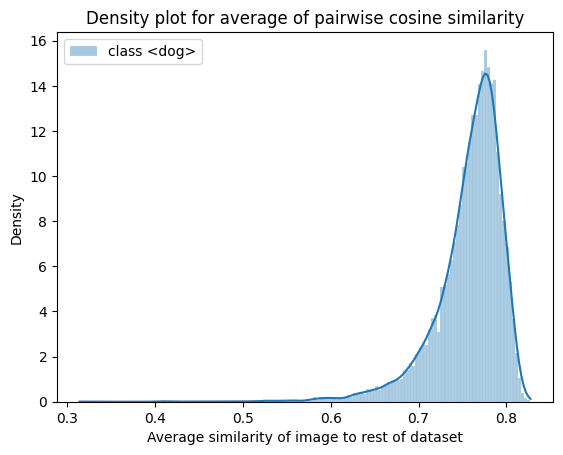

In [ ]:
density_plot([avg_similarity_imgs],["class <dog>"],
             title = "Density plot for average of pairwise cosine similarity")

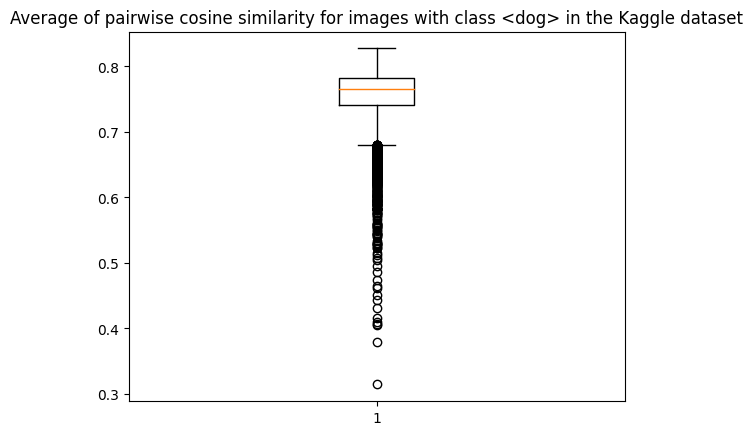

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Building the boxplot
ax.boxplot(avg_similarity_imgs)
ax.set_title("Average of pairwise cosine similarity for images with class <dog> in the Kaggle dataset")

# Displaying the plot
plt.show()

In [ ]:
def evaluate(similarity_values, ground_truth, predict_if_mislabeled_function, outliers_on_both_sides=False, stds_tolerated_searchspace=None, return_all=False, plot=False, mismatches=None, strategy=None, label=None):
  """
  CM in shape
  [[TN, FP],
   [FN, TP]]
  """

  if stds_tolerated_searchspace is None:
    stds_tolerated_searchspace = np.arange(0.1, 5.0001 if MISMATCH_PORTION >= 0.049 else 8.0001, 0.01)
  if mismatches is None:
    mismatches = {}
  if strategy is None:
    strategy = ''
  if label is None:
    label = ''

  precisions = []
  recalls = []
  recalls_per_type = {key: [] for key in mismatches}
  f1s = []
  accuracies = []
  confusion_matrices = []
  for stds_tolerated in stds_tolerated_searchspace:
    predictions = predict_if_mislabeled_function(similarity_values, outliers_on_both_sides, stds_tolerated)
    precisions.append(precision_score(ground_truth, predictions, zero_division=1.0))
    recalls.append(recall_score(ground_truth, predictions, zero_division=1.0))
    f1s.append(f1_score(ground_truth, predictions, zero_division=1.0))
    accuracies.append(accuracy_score(ground_truth, predictions))
    confusion_matrices.append(confusion_matrix(ground_truth, predictions, labels=[False, True]))
    for key in mismatches:
      recalls_per_type[key].append(recall_score(ground_truth[mismatches[key][0]:mismatches[key][1]], predictions[mismatches[key][0]:mismatches[key][1]], zero_division=0.0))

  best_index = np.argmax(f1s)
  best_metrics = {
      'stds_tolerated': stds_tolerated_searchspace[best_index],
      'f1': f1s[best_index],
      'precision': precisions[best_index],
      'recall': recalls[best_index],
      'accuracy': accuracies[best_index],
      'confusion_matrix': confusion_matrices[best_index]
  }
  for key in mismatches:
    best_metrics['recall_' + key] = recalls_per_type[key][best_index]

  if plot:
    plt.plot(stds_tolerated_searchspace, precisions, label='precision')
    plt.plot(stds_tolerated_searchspace, recalls, label='recall')
    plt.plot(stds_tolerated_searchspace, f1s, label='f1')
    plt.plot(stds_tolerated_searchspace, accuracies, label='accuracy')
    plt.title(f'Mismatch identification for class "{label}" with strategy "{strategy}"')
    plt.xlabel('stds_tolerated')
    plt.grid(linestyle='dotted')
    plt.legend()
    plt.show()

  if return_all:
    metrics = {
        'best_metrics': best_metrics,
        'all_metrics': {
            'stds_tolerated_searchspace': stds_tolerated_searchspace,
            'f1s': f1s,
            'precisions': precisions,
            'recalls': recalls,
            'accuracies': accuracies,
            'confusion_matrices': confusion_matrices
        }
    }
    for key in mismatches:
      metrics['all_metrics']['recall_' + key] = recalls_per_type[key][best_index]
    return metrics
  else:
    return best_metrics

In [ ]:
def predict_if_mismatch(similarity_values, outliers_on_both_sides=False, stds_tolerated=1):
  median_similarity = np.median(similarity_values)
  tolerated_deviation = stds_tolerated * np.std(similarity_values)
  if not outliers_on_both_sides:
    return similarity_values < median_similarity - tolerated_deviation
  else:
    outliers_high_value = similarity_values > median_similarity + tolerated_deviation
    outliers_low_value = similarity_values < median_similarity - tolerated_deviation
    outliers = np.logical_or(outliers_high_value, outliers_low_value)
    return outliers

In [ ]:
def calculate_column_average(matrix):
    """
    Calculates the average for each column in a PyTorch matrix.

    Parameters:
    - matrix: torch.Tensor
        The input matrix for which the column averages are to be calculated.

    Returns:
    - torch.Tensor
        A tensor containing the average value for each column of the input matrix.

    Raises:
    - TypeError:
        Raises an error if the input is not a PyTorch tensor.
    - ValueError:
        Raises an error if the input tensor is empty or has zero columns.
    """

    # Checking if the input is a PyTorch tensor
    if not isinstance(matrix, torch.Tensor):
        raise TypeError("Input should be a PyTorch tensor.")

    # Checking if the input tensor is empty or has zero columns
    if matrix.numel() == 0 or matrix.size(1) == 0:
        raise ValueError("Input tensor is empty or has zero columns.")

    # Calculating the column averages but taking out the entry for the same vector in the matrix (diagonal entry)
    column_sums = torch.sum(matrix, dim=0)
    column_counts = torch.tensor([matrix.size(0)] * (matrix.size(1)), dtype=torch.float32)
    column_averages = (column_sums -1) / (column_counts - 1)

    return column_averages

def cosine_similarity_matrix(embeddings_tensor):
    """
    Function to compute a similarity matrix using dot product

    Parameters:
    - embeddings: list of torch.Tensor
        List of embeddings of images produced with CLIP.

    Returns:
    - similarity_matrix: numpy.ndarray
        2D numpy array representing the similarity matrix between the embeddings.
        Each element (i, j) in the matrix represents the similarity between embeddings[i] and embeddings[j].
        The similarity score between the two embeddings is calculated using cos similarity. The score ranges from 0 to 1,
        where 0 indicates completely dissimilar embeddings and 1 indicates identical embeddings.
    """

    """
    # Calculating the cosine distance between the two embeddings
    distance = cosine(embedding1, embedding2)

    # Converting the distance to similarity score
    similarity = 1 - distance

    return similarity
    """

    # Normalizing the embeddings
    embeddings_tensor = torch.nn.functional.normalize(embeddings_tensor, dim=1)

    # Computing the similarity matrix using dot product
    similarity_matrix = torch.matmul(embeddings_tensor, embeddings_tensor.T)

    return similarity_matrix

from sklearn.metrics.pairwise import cosine_similarity as cosine_similarity_sklearn
def cosine_similarity(x, y=None):
  if y is None:
    return cosine_similarity_matrix(x)
  return cosine_similarity_sklearn(x, y)

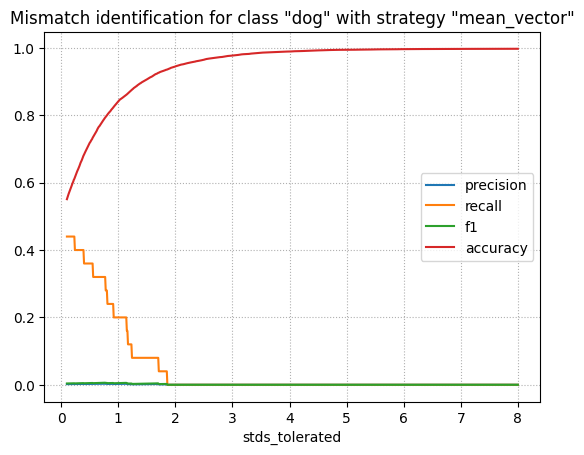

{'stds_tolerated': 0.7699999999999997,
 'f1': 0.006146753745678064,
 'precision': 0.0031031807602792862,
 'recall': 0.32,
 'accuracy': 0.79302344187535,
 'confusion_matrix': array([[9904, 2570],
        [  17,    8]])}

In [ ]:
reference_vector = torch.mean(image_embeddings["dog"], dim=0).unsqueeze(0)
similarity_values = [cos_sim[0] for cos_sim in cosine_similarity(image_embeddings["dog"], reference_vector)]

evaluate(similarity_values, ground_truth, predict_if_mismatch, outliers_on_both_sides=False, plot=True, strategy='mean_vector', label="dog", stds_tolerated_searchspace=np.arange(0.1, 8.0001, 0.01))